In [1]:
%pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 553.5 kB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from einops import rearrange, repeat
import math


train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

class mnistDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        img, label = self.dataset[index]
        return img, label

    def __len__(self):
        return len(self.dataset)

train_loader = torch.utils.data.DataLoader(dataset=mnistDataset(train_dataset), batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnistDataset(test_dataset), batch_size=64, shuffle=True)

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=7, in_chans=1, embed_dim=49):
        super().__init__()
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        # b, embedding, n_patches_h, n_patches_w

    def forward(self, x):
        x = self.proj(x)
        x = rearrange(x, 'b e n1 n2 -> b (n1 n2) e') # b, long, embedding
        return x


class MultiHeadAttention(nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()

        # key, query, value projections
        self.key = nn.Linear(n_embd, n_embd * n_heads)
        self.query = nn.Linear(n_embd, n_embd * n_heads)
        self.value = nn.Linear(n_embd, n_embd * n_heads)
        self.n_heads = n_heads

        # output projection
        self.proj = nn.Linear(n_embd * n_heads, n_embd)

        # for attention visualization
        self.att_maps = []

    def forward(self, x):
        # B, L, F = x.size() # batch, length, features

        k = rearrange(self.key(x), 'b l (h f) -> b h l f', h=self.n_heads) # (B, L, F) -> (B, H, L, F/H)
        q = rearrange(self.query(x), 'b l (h f) -> b h l f', h=self.n_heads) # (B, L, F) -> (B, H, L, F/H)
        v = rearrange(self.value(x), 'b l (h f) -> b h l f', h=self.n_heads) # (B, L, F) -> (B, H, L, F/H)

        scores = q @ k.transpose(-2,-1) / math.sqrt(k.size(-1)) # B, H, L, L
        att = F.softmax(scores, dim=-1)

        self.att_maps.append(att) #just for visualization

        y = att @ v # B, H, L, F/H

        y = rearrange(y, 'b h l f -> b l (h f)')


        y = self.proj(y) # batch, length, feature

        return y


class MultiLayerPerceptron(nn.Module):
    def __init__(self, n_embd, hidden_dim):
        super().__init__()

        self.MLP = nn.Sequential(
            nn.Linear(n_embd, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, n_embd)
        )

    def forward(self,x):
        x = self.MLP(x)
        return x


class TransformerEncoder(nn.Module):
    def __init__(self, n_embd, n_heads):
        super().__init__()

        self.att = MultiHeadAttention(n_embd, n_heads)
        self.ln1 = torch.nn.LayerNorm(n_embd)
        self.ln2 = torch.nn.LayerNorm(n_embd)
        self.mlp = MultiLayerPerceptron(n_embd, n_embd)

    def forward(self, x):

        x1 = self.ln1(x) #layer normalization
        x1 = self.att(x1) # multihead attention

        x = x + x1 # residual connection

        x2 = self.ln2(x) #layer normalization
        x2 = self.mlp(x2) # multilayer perceptron

        y = x + x2 # residual connection

        return y


class ViT(nn.Module):

    def __init__(self,img_dim , patch__dim=7, embed_dim=100, num_classes=10, n_heads=8, depth=2):
        super().__init__()


        self.patch_embed = PatchEmbedding(patch__dim, 1, embed_dim)
        self.cls_token = nn.Parameter( torch.randn(1, 1, embed_dim))

        n_patches = (img_dim // patch__dim) ** 2
        self.pos_embedding = nn.Parameter( torch.randn(1, n_patches+1, embed_dim))

        self.transformer = nn.Sequential(*[TransformerEncoder(embed_dim, n_heads) for _ in range(depth)])
        self.MLP_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):

        e = self.patch_embed(x) # (B, L, F)

        #cls token addition
        cls = repeat(self.cls_token, '1 1 f -> b 1 f', b=e.shape[0])
        e = torch.cat([cls, e], dim=1) + self.pos_embedding # (B, L+1, F)

        e += self.pos_embedding

        z = self.transformer(e) # (B, L+1, F)

        cls_token = z[:, 0, :]  # (B, F)

        y = self.MLP_head(cls_token) # (B, num_classes)

        return y

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ViT(img_dim=28,
            patch__dim=7,
            embed_dim=28,
            num_classes=10,
            n_heads=3,
            depth=2).to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for epoch in range(5):

    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print("Epoch: %d, Batch: %d, Loss: %f" % (epoch, i, loss.item()))


    correct = 0
    total = 0

    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print("Epoch: %d, Accuracy: %f" % (epoch, 100 * correct / total))



Epoch: 0, Batch: 0, Loss: 3.437751
Epoch: 0, Batch: 100, Loss: 0.491584
Epoch: 0, Batch: 200, Loss: 0.485637
Epoch: 0, Batch: 300, Loss: 0.373338
Epoch: 0, Batch: 400, Loss: 0.291904
Epoch: 0, Batch: 500, Loss: 0.261928
Epoch: 0, Batch: 600, Loss: 0.197681
Epoch: 0, Batch: 700, Loss: 0.327771
Epoch: 0, Batch: 800, Loss: 0.097286
Epoch: 0, Batch: 900, Loss: 0.121929
Epoch: 0, Accuracy: 94.079994
Epoch: 1, Batch: 0, Loss: 0.390047
Epoch: 1, Batch: 100, Loss: 0.150043
Epoch: 1, Batch: 200, Loss: 0.291350
Epoch: 1, Batch: 300, Loss: 0.281186
Epoch: 1, Batch: 400, Loss: 0.103496
Epoch: 1, Batch: 500, Loss: 0.178756
Epoch: 1, Batch: 600, Loss: 0.180868
Epoch: 1, Batch: 700, Loss: 0.188920
Epoch: 1, Batch: 800, Loss: 0.225493
Epoch: 1, Batch: 900, Loss: 0.051070
Epoch: 1, Accuracy: 95.279999
Epoch: 2, Batch: 0, Loss: 0.156373
Epoch: 2, Batch: 100, Loss: 0.065254
Epoch: 2, Batch: 200, Loss: 0.173717
Epoch: 2, Batch: 300, Loss: 0.173150
Epoch: 2, Batch: 400, Loss: 0.388910
Epoch: 2, Batch: 500,

In [84]:
import numpy as np

for layer in model.transformer:
    layer.att.att_maps.clear()

img_sample_test = test_dataset[0][0].unsqueeze(0).to(device)

output = model(img_sample_test)

result = torch.eye(17).to(device)
for layer in model.transformer:
    att = layer.att.att_maps

    attention_heads_fused = att[0].max(axis=1)[0]

    flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
    _, indices = flat.topk(int(flat.size(-1)*0.9), -1, False)
    indices = indices[indices != 0]
    flat[0, indices] = 0

    I = torch.eye(attention_heads_fused.size(-1)).to(device)
    a = (attention_heads_fused + 1.0*I)/2
    a = a / a.sum(dim=-1)

    result = torch.matmul(a, result)

mask = result[0,0,1:]
mask= mask.reshape(4,4).detach().cpu().numpy()

mask = mask / np.max(mask)

In [85]:
import cv2
def show_mask_on_image(img, mask):
    img = np.float32(img)
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

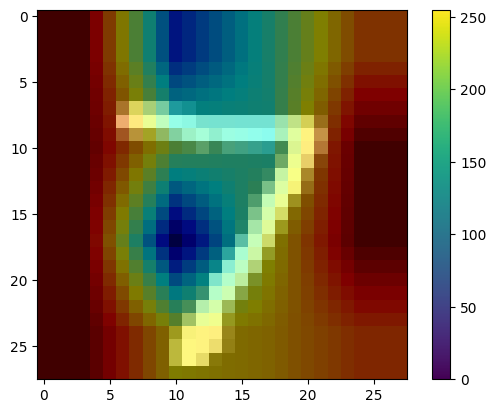

In [86]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

np_img = img_sample_test.squeeze().cpu().unsqueeze(-1).numpy()
mask = cv2.resize(mask, (28,28))
mask = show_mask_on_image(np_img, mask)

plt.imshow(mask)
plt.colorbar()

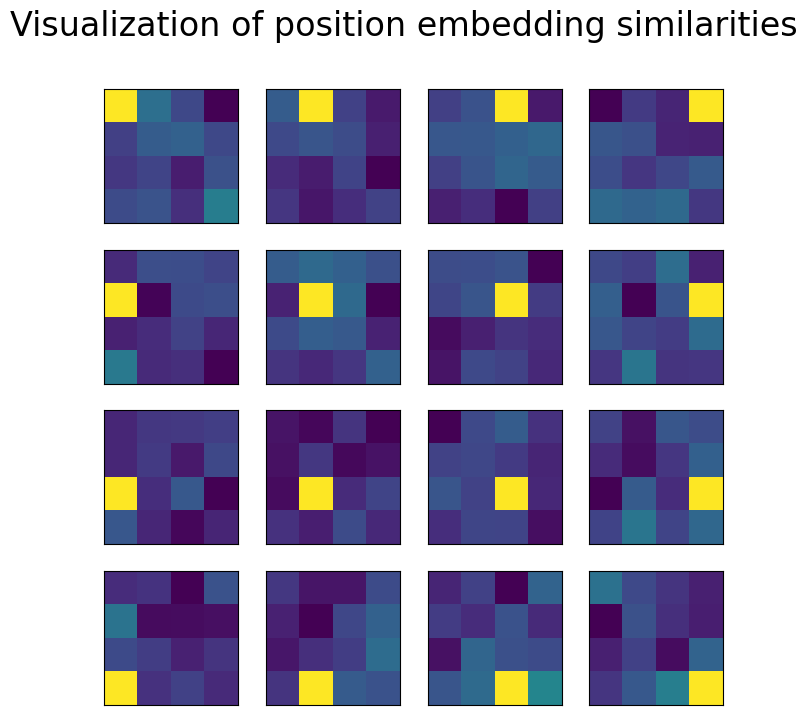

In [4]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

pos = model.pos_embedding[:,1:,:].squeeze()
#pos = rearrange(pos, "(h w) (p1 p2) ->  (h p1) (w p2)", p1=7, p2=7, h=4, w=4)

F.cosine_similarity( pos[0:2,:].detach() , pos[0:2,:].detach() )

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(0, pos.shape[0]):

    sim = F.cosine_similarity(pos[i:i+1], pos, dim=1)
    sim = sim.reshape((4, 4)).detach().cpu().numpy()

    ax = fig.add_subplot(4, 4, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)